## Feature-Based Image Warping and Seamless Overlay

This cell implements a complete **planar image overlay pipeline** using classical computer vision techniques. The goal is to warp a source image onto a target surface in another image and blend it naturally.

### Visualization Utility
A helper function is defined to display one or more images consistently, handling:
- Automatic BGR → RGB conversion
- Grayscale and multi-channel inputs
- Proper intensity scaling for float images  
This simplifies debugging and visual comparison at each stage.

### SIFT Feature Matching
A reusable `SIFTMatcher` class is introduced to establish correspondences between two images:
- Detects scale- and rotation-invariant keypoints using **SIFT**
- Matches descriptors via **Brute-Force L2 matching**
- Applies **Lowe’s ratio test** to filter ambiguous matches  
The output is a set of reliable 2D point correspondences.

### Robust Homography Estimation
Using matched points, a **homography matrix** is computed with:
- `cv2.findHomography`
- **RANSAC** to reject outliers  
This estimates the projective transformation that maps one image plane onto another.

### Perspective Warping and Feathered Blending
The source image is warped into the destination frame using the estimated homography. To avoid hard edges:
- A binary visibility mask is generated
- The mask is **Gaussian-blurred** to create a feathered alpha map
- Warped content is blended smoothly into the destination image

This produces a visually seamless composite instead of a sharp cut-and-paste.

### Point Ordering for Geometric Consistency
A utility function ensures that corner points are consistently ordered
(top-left → top-right → bottom-right → bottom-left), which is critical for stable homography estimation.

### Manual Planar Overlay
For controlled placement:
- Source image corners are mapped to manually selected quadrilateral points on the destination image
- The homography is computed directly from these correspondences
- The source image is warped and blended onto the target surface

### Output
- The original and composited images are visualized side-by-side
- The final result is saved to disk for later use

Overall, this cell demonstrates a **classical augmented-reality style overlay** using feature geometry, homographies, and soft blending.


In [21]:
from google.colab import drive
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def show_images(imgs, titles=None, cmap=None):
    if isinstance(imgs, np.ndarray):
        imgs = [imgs]
    imgs = list(imgs)
    n = len(imgs)
    if titles is None:
        titles = [''] * n
    if cmap is None:
        cmaps = [None] * n
    elif isinstance(cmap, (list, tuple)):
        cmaps = list(cmap) + [None] * max(0, n - len(cmap))
    else:
        cmaps = [cmap] * n
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]
    for ax, img, title, cm in zip(axes, imgs, titles, cmaps):
        if img is None:
            ax.axis('off')
            continue
        arr = np.array(img)
        if arr.ndim == 3:
            if arr.shape[2] == 3:
                try:
                    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
                except:
                    arr = arr[..., ::-1]
            elif arr.shape[2] == 4:
                try:
                    arr = cv2.cvtColor(arr, cv2.COLOR_BGRA2RGBA)
                except:
                    arr = arr[..., :3][..., ::-1]
        if np.issubdtype(arr.dtype, np.integer):
            ax.imshow(arr, cmap=cm)
        else:
            vmin = float(np.nanmin(arr)) if np.isfinite(arr).any() else None
            vmax = float(np.nanmax(arr)) if np.isfinite(arr).any() else None
            ax.imshow(arr, cmap=cm, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
class SIFTMatcher:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.bf = cv2.BFMatcher(cv2.NORM_L2)

    def find_matches(self, imgA, imgB, ratio_thresh=0.75):
        grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY) if imgA.ndim == 3 else imgA
        grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY) if imgB.ndim == 3 else imgB
        kpA, desA = self.sift.detectAndCompute(grayA, None)
        kpB, desB = self.sift.detectAndCompute(grayB, None)
        if desA is None or desB is None:
            return np.empty((0, 2), dtype=np.float32), np.empty((0, 2), dtype=np.float32)
        matches = self.bf.knnMatch(desA, desB, k=2)
        good = []
        for m_n in matches:
            if len(m_n) != 2:
                continue
            m, n = m_n
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
        if len(good) < 4:
            return np.empty((0, 2), dtype=np.float32), np.empty((0, 2), dtype=np.float32)
        ptsA = np.float32([kpA[m.queryIdx].pt for m in good])
        ptsB = np.float32([kpB[m.trainIdx].pt for m in good])
        return ptsA, ptsB


In [ ]:
def compute_homography(ptsA, ptsB, ransac_thresh=5.0):
    if ptsA is None or ptsB is None:
        return None, None
    if len(ptsA) < 4 or len(ptsB) < 4:
        return None, None
    H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransac_thresh)
    if mask is None:
        return H, None
    return H, mask.ravel().astype(bool)


In [ ]:
def feather_mask(img, k=21):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    _, th = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    k = k if k % 2 == 1 else k + 1
    blur = cv2.GaussianBlur(th, (k, k), 0)
    mask = blur.astype(np.float32) / 255.0
    if img.ndim == 3:
        mask = np.repeat(mask[:, :, None], 3, axis=2)
    return mask

def warp_and_composite(src, dst, H, feather_ksize=31):
    h_dst, w_dst = dst.shape[:2]
    warped_src = cv2.warpPerspective(src, H, (w_dst, h_dst))
    if src.ndim == 3 and src.shape[2] == 4:
        if warped_src.ndim == 3 and warped_src.shape[2] == 4:
            warped_rgb = warped_src[:, :, :3]
            warped_alpha = warped_src[:, :, 3]
            mask_src = warped_alpha
        else:
            warped_rgb = warped_src[:, :, :3]
            gray_src = cv2.cvtColor(src[:, :, :3], cv2.COLOR_BGR2GRAY)
            _, mask_src = cv2.threshold(gray_src, 1, 255, cv2.THRESH_BINARY)
            warped_mask = cv2.warpPerspective(mask_src, H, (w_dst, h_dst))
            mask_src = warped_mask
    else:
        if src.ndim == 2:
            gray_src = src
        else:
            gray_src = cv2.cvtColor(src[:, :, :3], cv2.COLOR_BGR2GRAY)
        _, mask_src = cv2.threshold(gray_src, 1, 255, cv2.THRESH_BINARY)
        warped_mask = cv2.warpPerspective(mask_src, H, (w_dst, h_dst))
        mask_src = warped_mask
        warped_rgb = warped_src if warped_src.ndim == 3 else cv2.cvtColor(warped_src, cv2.COLOR_GRAY2BGR)
    warped_mask_final = warped_mask if 'warped_mask' in locals() else (mask_src if mask_src.ndim == 2 else cv2.cvtColor(mask_src, cv2.COLOR_BGR2GRAY))
    feather = feather_mask(warped_mask_final, k=feather_ksize)
    if feather.ndim == 2:
        feather = np.repeat(feather[:, :, None], 3, axis=2)
    dst_f = dst.astype(np.float32)
    warped_f = warped_rgb.astype(np.float32)
    out = dst_f * (1.0 - feather) + warped_f * feather
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out


In [5]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
drive_root = Path('/content/drive/MyDrive')

Mounted at /content/drive


Source image size: 1080x608
Ordered destination points:
[[ 422.  152.]
 [1132.  171.]
 [1120.  560.]
 [ 433.  548.]]
Ordered source points:
[[   0.    0.]
 [1080.    0.]
 [1080.  608.]
 [   0.  608.]]

Homography matrix:
[[6.75176617e-01 4.21456934e-02 4.22000000e+02]
 [2.02768106e-02 6.81757744e-01 1.52000000e+02]
 [1.56971813e-05 5.55510119e-05 1.00000000e+00]]


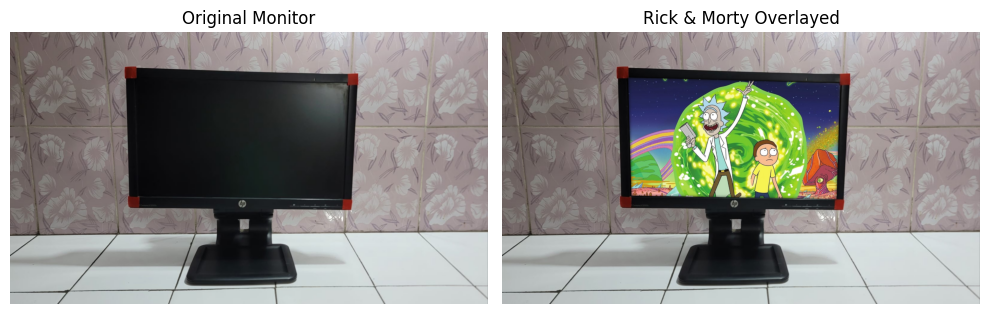


✓ Result saved to: task_A1_manual_result.png


In [ ]:
def order_points(pts):
    pts = np.array(pts, dtype=np.float32)

    sorted_by_y = pts[np.argsort(pts[:, 1])]

    top_pts = sorted_by_y[:2]
    bottom_pts = sorted_by_y[2:]

    top_left = top_pts[np.argmin(top_pts[:, 0])]
    top_right = top_pts[np.argmax(top_pts[:, 0])]

    bottom_left = bottom_pts[np.argmin(bottom_pts[:, 0])]
    bottom_right = bottom_pts[np.argmax(bottom_pts[:, 0])]

    return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)


# Load images
src = cv2.imread('/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/rick_and_morty.jpg', cv2.IMREAD_UNCHANGED)
dst = cv2.imread('/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/monitor.jpg', cv2.IMREAD_COLOR)

if src is None or dst is None:
    raise FileNotFoundError('One or both image paths are incorrect or files are missing')

h_src, w_src = src.shape[:2]

dst_pts = np.array([
    [422, 152],   # top left
    [433, 548],   # bottom left
    [1132, 171],  # top right
    [1120, 560]   # bottom right
], dtype=np.float32)

dst_pts = order_points(dst_pts)

src_pts = np.array([
    [0, 0],
    [w_src, 0],
    [w_src, h_src],
    [0, h_src]
], dtype=np.float32)
src_pts = order_points(src_pts)

print(f"Source image size: {w_src}x{h_src}")
print(f"Ordered destination points:\n{dst_pts}")
print(f"Ordered source points:\n{src_pts}")

H, mask = compute_homography(src_pts, dst_pts)
if H is None:
    raise RuntimeError('Homography estimation failed')

print(f"\nHomography matrix:\n{H}")

result = warp_and_composite(src, dst, H, feather_ksize=31)

show_images([dst, result], titles=['Original Monitor', 'Rick & Morty Overlayed'])

out_path = Path('task_A1_manual_result.png')
cv2.imwrite(str(out_path), result)
print(f'\n✓ Result saved to: {out_path}')

## Stable Augmented Reality Overlay on Video

This cell extends the planar image overlay pipeline to **videos**, performing robust **frame-by-frame tracking** and **temporally stable warping** using feature-based geometry.

---

### Reference Frame Initialization
A single reference frame is extracted from the target video:
- **SIFT keypoints and descriptors** are computed once on this frame
- Manually annotated monitor corner points define the planar surface
- These reference features act as a stable anchor for all subsequent frames

---

### Frame-to-Frame Feature Tracking
For each video frame:
- SIFT keypoints are detected and matched against the reference frame
- **Lowe’s ratio test** filters unreliable matches
- A **RANSAC-based homography** maps the reference frame to the current frame  
This allows the monitor plane to be tracked even under motion and perspective change.

---

### Dynamic Homography Transfer
The detected reference-to-frame homography is used to:
- Project the reference monitor corners into the current frame
- Estimate a new homography that maps the overlay content directly onto the tracked monitor surface  
This decouples surface tracking from overlay geometry.

---

### Temporal Homography Smoothing
To reduce jitter and sudden jumps:
- Recent homographies are stored in a sliding buffer
- **Exponentially weighted averaging** is applied
- The smoothed homography is used for rendering  
This significantly improves visual stability in dynamic scenes.

---

### Robust Fallback Strategy
If tracking fails due to:
- Insufficient matches
- Low inlier ratio
- Degenerate homography  
the system reuses the **last valid homography**, ensuring continuity without flicker.

---

### Feathered Warping and Blending
Each overlay (image or video frame) is:
- Perspective-warped using the smoothed homography
- Blended using a **soft feather mask**  
This avoids harsh edges and maintains visual realism.

---

### Task A2: Image-on-Video Overlay
A static image is projected onto the tracked monitor across all video frames:
- Suitable for posters, screens, or billboard augmentation
- Maintains alignment despite camera motion

---

### Task A3: Video-on-Video Overlay
A dynamic source video is:
- Played frame-by-frame
- Warped onto the tracked monitor surface
- Looped automatically if shorter than the target video  
This produces a realistic “video playing on a screen” effect.

---

### Output
- Fully processed videos are written frame-by-frame
- Progress and success statistics are logged
- Final augmented videos are saved to disk

This cell demonstrates a **complete classical AR pipeline** combining feature tracking, projective geometry, temporal filtering, and seamless compositing.


In [ ]:

def overlay_image_on_video_final(video_path, overlay_img, out_path,
                                   monitor_corners_ref, N=15):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, reference_frame = cap.read()
    if not ret:
        raise RuntimeError("Cannot read reference frame")

    gray_ref = cv2.cvtColor(reference_frame, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create(nfeatures=3000)
    kp_ref, des_ref = sift.detectAndCompute(gray_ref, None)

    print(f"Reference frame: detected {len(kp_ref)} keypoints")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    h_overlay, w_overlay = overlay_img.shape[:2]

    src_pts = np.float32([[0, 0], [w_overlay, 0], [w_overlay, h_overlay], [0, h_overlay]])

    dst_pts_ref = np.array(monitor_corners_ref, dtype=np.float32)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    H_buffer = []
    last_valid_H = None

    print(f"\nProcessing video: {total_frames} frames at {fps} FPS")
    print(f"Monitor corners in reference frame:")
    print(f"  Top-left: {monitor_corners_ref[0]}")
    print(f"  Top-right: {monitor_corners_ref[1]}")
    print(f"  Bottom-right: {monitor_corners_ref[2]}")
    print(f"  Bottom-left: {monitor_corners_ref[3]}")
    print()

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    success_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        kp_frame, des_frame = sift.detectAndCompute(gray_frame, None)

        if des_frame is None or len(kp_frame) < 10:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        matches = bf.knnMatch(des_ref, des_frame, k=2)

        good = []
        for m_n in matches:
            if len(m_n) != 2:
                continue
            m, n = m_n
            if m.distance < 0.75 * n.distance:
                good.append(m)

        if len(good) < 15:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in good])
        pts_frame = np.float32([kp_frame[m.trainIdx].pt for m in good])

        H_ref_to_frame, mask = cv2.findHomography(pts_ref, pts_frame, cv2.RANSAC, 5.0)

        if H_ref_to_frame is None or mask is None:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        inlier_ratio = np.sum(mask) / len(mask)
        if inlier_ratio < 0.3:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        dst_pts_ref_homog = np.hstack([dst_pts_ref, np.ones((4, 1))])
        dst_pts_curr_homog = H_ref_to_frame @ dst_pts_ref_homog.T
        dst_pts_curr = (dst_pts_curr_homog[:2, :] / dst_pts_curr_homog[2, :]).T

        H_overlay, _ = cv2.findHomography(src_pts, dst_pts_curr, 0)

        if H_overlay is None:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        H_buffer.append(H_overlay)
        if len(H_buffer) > N:
            H_buffer.pop(0)

        weights = np.exp(np.linspace(-1.5, 0, len(H_buffer)))
        weights /= weights.sum()

        H_smooth = np.zeros_like(H_buffer[0])
        for i, H in enumerate(H_buffer):
            H_smooth += weights[i] * H

        last_valid_H = H_smooth.copy()

        result = warp_and_composite(overlay_img, frame, H_smooth, feather_ksize=21)

        out.write(result)
        success_count += 1

        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames} frames (successful: {success_count})")

    cap.release()
    out.release()
    print(f"\n✓ Video processing complete!")
    print(f"✓ Successfully processed {success_count}/{total_frames} frames")
    print(f"✓ Video saved to: {out_path}")
    return out_path


video_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/monitor_video1.mp4'
overlay_img_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/rick_and_morty.jpg'

overlay_img = cv2.imread(overlay_img_path, cv2.IMREAD_UNCHANGED)
if overlay_img is None:
    raise FileNotFoundError(f"Cannot load overlay image: {overlay_img_path}")

monitor_corners = [
    [212, 50],    # top-left
    [545, 58],    # top-right
    [540, 240],   # bottom-right
    [220, 235]    # bottom-left
]

out_path = 'task_A2_final.mp4'

overlay_image_on_video_final(
    video_path,
    overlay_img,
    out_path,
    monitor_corners,
    N=15
)

print("\n" + "="*60)
print("Processing Done.")
print("="*60)


Reference frame: detected 240 keypoints

Processing video: 287 frames at 30 FPS
Monitor corners in reference frame:
  Top-left: [212, 50]
  Top-right: [545, 58]
  Bottom-right: [540, 240]
  Bottom-left: [220, 235]

Processed 30/287 frames (successful: 30)
Processed 60/287 frames (successful: 60)
Processed 90/287 frames (successful: 90)
Processed 120/287 frames (successful: 120)
Processed 150/287 frames (successful: 146)
Processed 180/287 frames (successful: 176)
Processed 210/287 frames (successful: 206)
Processed 240/287 frames (successful: 236)
Processed 270/287 frames (successful: 266)

✓ Video processing complete!
✓ Successfully processed 283/287 frames
✓ Video saved to: task_A2_final.mp4

Processing Done.


In [17]:
from google.colab import files

# Download the video
files.download('task_A2_final.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def overlay_video_on_video(target_path, src_path, out_path, monitor_corners_ref, N=15):
    cap_target = cv2.VideoCapture(str(target_path))
    cap_src = cv2.VideoCapture(str(src_path))

    if not cap_target.isOpened():
        raise RuntimeError(f"Cannot open target video: {target_path}")
    if not cap_src.isOpened():
        raise RuntimeError(f"Cannot open source video: {src_path}")

    fps = int(cap_target.get(cv2.CAP_PROP_FPS))
    width = int(cap_target.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_target.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames_target = int(cap_target.get(cv2.CAP_PROP_FRAME_COUNT))

    total_frames_src = int(cap_src.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Target video: {total_frames_target} frames")
    print(f"Source video: {total_frames_src} frames")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    ret, reference_frame = cap_target.read()
    if not ret:
        raise RuntimeError("Cannot read reference frame from target video")

    gray_ref = cv2.cvtColor(reference_frame, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create(nfeatures=3000)
    kp_ref, des_ref = sift.detectAndCompute(gray_ref, None)

    print(f"Reference frame: detected {len(kp_ref)} keypoints")

    dst_pts_ref = np.array(monitor_corners_ref, dtype=np.float32)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    H_buffer = []
    last_valid_H = None

    print(f"\nProcessing videos:")
    print(f"Monitor corners in reference frame:")
    print(f"  Top-left: {monitor_corners_ref[0]}")
    print(f"  Top-right: {monitor_corners_ref[1]}")
    print(f"  Bottom-right: {monitor_corners_ref[2]}")
    print(f"  Bottom-left: {monitor_corners_ref[3]}")
    print()

    cap_target.set(cv2.CAP_PROP_POS_FRAMES, 0)
    cap_src.set(cv2.CAP_PROP_POS_FRAMES, 0)

    frame_count = 0
    success_count = 0
    src_frame_idx = 0

    while True:
        ret_target, target_frame = cap_target.read()
        if not ret_target:
            break

        ret_src, src_frame = cap_src.read()
        if not ret_src:
            cap_src.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret_src, src_frame = cap_src.read()
            src_frame_idx = 0
            if not ret_src:
                print("Warning: Cannot read source video frame")
                out.write(target_frame)
                frame_count += 1
                continue

        frame_count += 1
        src_frame_idx += 1

        gray_target = cv2.cvtColor(target_frame, cv2.COLOR_BGR2GRAY)

        h_src, w_src = src_frame.shape[:2]
        src_pts = np.float32([[0, 0], [w_src, 0], [w_src, h_src], [0, h_src]])

        kp_target, des_target = sift.detectAndCompute(gray_target, None)

        if des_target is None or len(kp_target) < 10:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        matches = bf.knnMatch(des_ref, des_target, k=2)

        good = []
        for m_n in matches:
            if len(m_n) != 2:
                continue
            m, n = m_n
            if m.distance < 0.75 * n.distance:
                good.append(m)

        if len(good) < 15:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in good])
        pts_target = np.float32([kp_target[m.trainIdx].pt for m in good])

        H_ref_to_target, mask = cv2.findHomography(pts_ref, pts_target, cv2.RANSAC, 5.0)

        if H_ref_to_target is None or mask is None:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        inlier_ratio = np.sum(mask) / len(mask)
        if inlier_ratio < 0.3:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        dst_pts_ref_homog = np.hstack([dst_pts_ref, np.ones((4, 1))])
        dst_pts_curr_homog = H_ref_to_target @ dst_pts_ref_homog.T
        dst_pts_curr = (dst_pts_curr_homog[:2, :] / dst_pts_curr_homog[2, :]).T

        H_overlay, _ = cv2.findHomography(src_pts, dst_pts_curr, 0)

        if H_overlay is None:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        H_buffer.append(H_overlay)
        if len(H_buffer) > N:
            H_buffer.pop(0)

        weights = np.exp(np.linspace(-1.5, 0, len(H_buffer)))
        weights /= weights.sum()

        H_smooth = np.zeros_like(H_buffer[0])
        for i, H in enumerate(H_buffer):
            H_smooth += weights[i] * H

        last_valid_H = H_smooth.copy()

        result = warp_and_composite(src_frame, target_frame, H_smooth, feather_ksize=21)

        out.write(result)
        success_count += 1

        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames_target} frames (successful: {success_count})")

    cap_target.release()
    cap_src.release()
    out.release()

    print(f"\n✓ Video processing complete!")
    print(f"✓ Successfully processed {success_count}/{frame_count} frames")
    print(f"✓ Video saved to: {out_path}")
    return out_path


target_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/monitor_video1.mp4'
src_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/R&M_clip.mp4'
out_path = 'task_A3_result.mp4'

monitor_corners = [
    [212, 50],    # top-left
    [545, 58],    # top-right
    [540, 240],   # bottom-right
    [220, 235]    # bottom-left
]

overlay_video_on_video(
    target_path=target_path,
    src_path=src_path,
    out_path=out_path,
    monitor_corners_ref=monitor_corners,
    N=15
)

print("\n" + "="*60)
print("Processing Done.")
print("="*60)


Target video: 287 frames
Source video: 543 frames
Reference frame: detected 240 keypoints

Processing videos:
Monitor corners in reference frame:
  Top-left: [212, 50]
  Top-right: [545, 58]
  Bottom-right: [540, 240]
  Bottom-left: [220, 235]

Processed 30/287 frames (successful: 30)
Processed 60/287 frames (successful: 60)
Processed 90/287 frames (successful: 90)
Processed 120/287 frames (successful: 120)
Processed 150/287 frames (successful: 146)
Processed 180/287 frames (successful: 176)
Processed 210/287 frames (successful: 206)
Processed 240/287 frames (successful: 236)
Processed 270/287 frames (successful: 266)

✓ Video processing complete!
✓ Successfully processed 283/287 frames
✓ Video saved to: task_A3_result.mp4

Processing Done.


In [35]:
from google.colab import files

# Download the video
files.download('task_A3_result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Deep Learning–Based Video Augmentation with SuperGlue

This cell upgrades the video augmentation pipeline by replacing classical feature matching with **SuperPoint + SuperGlue**, a learned correspondence model that provides more robust and consistent matches under viewpoint changes, blur, and low texture.

---

### SuperPoint + SuperGlue Matching Pipeline
Instead of hand-crafted descriptors:
- **SuperPoint** detects keypoints and computes learned descriptors
- **SuperGlue** performs graph-based matching using attention and context reasoning  
This yields fewer but significantly more reliable correspondences than SIFT.

The matcher outputs:
- Matched keypoints in both images
- Implicit confidence filtering via learned matching scores

---

### Reference-Based Planar Tracking
A single reference frame from the target video is used as the anchor:
- Monitor corner points are defined in this frame
- SuperGlue matches the reference frame to each incoming frame
- A **RANSAC homography** estimates the planar motion of the monitor surface

This enables stable tracking even with challenging camera motion.

---

### Homography Transfer for Overlay Placement
The estimated reference-to-frame homography is used to:
- Project reference monitor corners into the current frame
- Compute a second homography mapping overlay content onto the tracked surface  
This two-step strategy cleanly separates **tracking** from **rendering**.

---

### Temporal Homography Smoothing
To suppress frame-to-frame jitter:
- Recent homographies are stored in a sliding window
- **Exponentially weighted averaging** favors recent frames while preserving stability
- The smoothed homography is used for warping

This significantly improves perceptual smoothness.

---

### Robust Failure Handling
If SuperGlue matching or homography estimation fails:
- The pipeline falls back to the **last valid homography**
- This avoids visual flicker, dropped overlays, or abrupt jumps

---

### Task A2 (Deep Learning): Image on Video
A static image is projected onto the moving monitor:
- Maintains alignment across frames
- Handles motion blur and viewpoint changes better than SIFT
- Produces visibly more stable overlays

---

### Task A3 (Deep Learning): Video on Video
A source video is dynamically:
- Warped frame-by-frame onto the tracked surface
- Loop-played if shorter than the target video
- Blended seamlessly using feathered compositing

This creates a realistic “video playing inside a video” effect.

---

### Key Advantage over Classical Matching
Compared to SIFT-based tracking:
- Fewer false matches
- Higher inlier ratios
- Better robustness under illumination and perspective changes  
This makes SuperGlue particularly effective for **real-world AR scenarios**.

---

### Output
- Augmented videos are written to disk
- Processing statistics are logged during execution
- Final results demonstrate stable, deep-learning-powered planar AR

This cell showcases a **modern, learning-based alternative** to classical feature pipelines for video augmentation.


In [36]:
# ==============================================================
# SuperGlue Matcher (PyTorch + SuperPoint + SuperGlue)
# ==============================================================

import torch
import sys
import os

# Clone SuperGlue repo if not already present
if not os.path.exists("superglue_pretrained"):
    !git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git superglue_pretrained

# Add cloned repo to path
sys.path.append("superglue_pretrained")

# Import necessary modules
from models.matching import Matching
from models.utils import frame2tensor

# Select best device available
if torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # CPU fallback

print(f"⚡ Using device: {device}")

# Load SuperGlue + SuperPoint models with pretrained weights
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'outdoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2
    }
}

matching = Matching(config).eval().to(device)

Cloning into 'superglue_pretrained'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 184 (from 2)
Receiving objects: 100% (185/185), 118.85 MiB | 42.81 MiB/s, done.
Resolving deltas: 100% (52/52), done.
⚡ Using device: cuda
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [ ]:

class SuperGlueMatcher:
    def __init__(self, pretrained_model):
        self.matching = pretrained_model
        self.device = next(pretrained_model.parameters()).device

    def find_matches(self, imgA, imgB):
        if imgA.ndim == 3:
            grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
        else:
            grayA = imgA

        if imgB.ndim == 3:
            grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
        else:
            grayB = imgB

        inp0 = frame2tensor(grayA, self.device)
        inp1 = frame2tensor(grayB, self.device)

        with torch.no_grad():
            pred = self.matching({'image0': inp0, 'image1': inp1})

        kpts0 = pred['keypoints0'][0].cpu().numpy()  # Keypoints in imgA
        kpts1 = pred['keypoints1'][0].cpu().numpy()  # Keypoints in imgB
        matches = pred['matches0'][0].cpu().numpy()   # Match indices
        confidence = pred['matching_scores0'][0].cpu().numpy()  # Match confidence

        valid = matches > -1

        if valid.sum() == 0:
            return np.empty((0, 2), dtype=np.float32), np.empty((0, 2), dtype=np.float32)

        mkpts0 = kpts0[valid]  
        mkpts1 = kpts1[matches[valid]]  

        ptsA = mkpts0.astype(np.float32)
        ptsB = mkpts1.astype(np.float32)

        return ptsA, ptsB

In [ ]:
superglue_matcher = SuperGlueMatcher(pretrained_model=matching)

video_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/monitor_video1.mp4'
overlay_img_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/rick_and_morty.jpg'

overlay_img = cv2.imread(overlay_img_path, cv2.IMREAD_UNCHANGED)
if overlay_img is None:
    raise FileNotFoundError(f"Cannot load overlay image: {overlay_img_path}")

monitor_corners = [
    [212, 50],    # top-left
    [545, 58],    # top-right
    [540, 240],   # bottom-right
    [220, 235]    # bottom-left
]

out_path = 'task_A2_superglue.mp4'

print("="*60)
print("Task A2 with SuperGlue - Image on Video")
print("="*60)


def overlay_image_on_video_superglue(video_path, overlay_img, out_path,
                                      matcher, monitor_corners_ref, N=15):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, reference_frame = cap.read()
    if not ret:
        raise RuntimeError("Cannot read reference frame")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    h_overlay, w_overlay = overlay_img.shape[:2]
    src_pts = np.float32([[0, 0], [w_overlay, 0], [w_overlay, h_overlay], [0, h_overlay]])
    dst_pts_ref = np.array(monitor_corners_ref, dtype=np.float32)

    H_buffer = []
    last_valid_H = None

    print(f"\nProcessing video: {total_frames} frames at {fps} FPS")
    print(f"Using SuperGlue matcher")

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    success_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        pts_ref, pts_frame = matcher.find_matches(reference_frame, frame)

        if len(pts_ref) < 15:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        H_ref_to_frame, mask = cv2.findHomography(pts_ref, pts_frame, cv2.RANSAC, 5.0)

        if H_ref_to_frame is None or mask is None:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        inlier_ratio = np.sum(mask) / len(mask)
        if inlier_ratio < 0.3:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        dst_pts_ref_homog = np.hstack([dst_pts_ref, np.ones((4, 1))])
        dst_pts_curr_homog = H_ref_to_frame @ dst_pts_ref_homog.T
        dst_pts_curr = (dst_pts_curr_homog[:2, :] / dst_pts_curr_homog[2, :]).T

        H_overlay, _ = cv2.findHomography(src_pts, dst_pts_curr, 0)

        if H_overlay is None:
            if last_valid_H is not None:
                result = warp_and_composite(overlay_img, frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(frame)
            continue

        H_buffer.append(H_overlay)
        if len(H_buffer) > N:
            H_buffer.pop(0)

        weights = np.exp(np.linspace(-1.5, 0, len(H_buffer)))
        weights /= weights.sum()

        H_smooth = np.zeros_like(H_buffer[0])
        for i, H in enumerate(H_buffer):
            H_smooth += weights[i] * H

        last_valid_H = H_smooth.copy()
        result = warp_and_composite(overlay_img, frame, H_smooth, feather_ksize=21)

        out.write(result)
        success_count += 1

        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames} frames (successful: {success_count})")

    cap.release()
    out.release()
    print(f"\n✓ Video saved to: {out_path}")
    print(f"✓ Successfully processed {success_count}/{total_frames} frames")
    return out_path

# Run with SuperGlue
overlay_image_on_video_superglue(
    video_path,
    overlay_img,
    out_path,
    superglue_matcher,
    monitor_corners,
    N=15
)


Task A2 with SuperGlue - Image on Video

Processing video: 287 frames at 30 FPS
Using SuperGlue matcher
Processed 30/287 frames (successful: 30)
Processed 60/287 frames (successful: 60)
Processed 90/287 frames (successful: 90)
Processed 120/287 frames (successful: 120)
Processed 150/287 frames (successful: 150)
Processed 180/287 frames (successful: 180)
Processed 210/287 frames (successful: 210)
Processed 240/287 frames (successful: 240)
Processed 270/287 frames (successful: 270)

✓ Video saved to: task_A2_superglue.mp4
✓ Successfully processed 287/287 frames


'task_A2_superglue.mp4'

In [40]:
from google.colab import files

# Download the video
files.download('task_A2_superglue.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

def overlay_video_on_video_superglue(target_path, src_path, out_path,
                                      matcher, monitor_corners_ref, N=15):
    cap_target = cv2.VideoCapture(str(target_path))
    cap_src = cv2.VideoCapture(str(src_path))

    if not cap_target.isOpened():
        raise RuntimeError(f"Cannot open target video: {target_path}")
    if not cap_src.isOpened():
        raise RuntimeError(f"Cannot open source video: {src_path}")

    fps = int(cap_target.get(cv2.CAP_PROP_FPS))
    width = int(cap_target.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_target.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames_target = int(cap_target.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames_src = int(cap_src.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Target video: {total_frames_target} frames")
    print(f"Source video: {total_frames_src} frames")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    ret, reference_frame = cap_target.read()
    if not ret:
        raise RuntimeError("Cannot read reference frame from target video")

    dst_pts_ref = np.array(monitor_corners_ref, dtype=np.float32)

    H_buffer = []
    last_valid_H = None

    print(f"\nProcessing videos with SuperGlue matcher:")

    cap_target.set(cv2.CAP_PROP_POS_FRAMES, 0)
    cap_src.set(cv2.CAP_PROP_POS_FRAMES, 0)

    frame_count = 0
    success_count = 0

    while True:
        ret_target, target_frame = cap_target.read()
        if not ret_target:
            break

        ret_src, src_frame = cap_src.read()
        if not ret_src:
            cap_src.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret_src, src_frame = cap_src.read()
            if not ret_src:
                out.write(target_frame)
                frame_count += 1
                continue

        frame_count += 1

        h_src, w_src = src_frame.shape[:2]
        src_pts = np.float32([[0, 0], [w_src, 0], [w_src, h_src], [0, h_src]])

        pts_ref, pts_target = matcher.find_matches(reference_frame, target_frame)

        if len(pts_ref) < 15:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        H_ref_to_target, mask = cv2.findHomography(pts_ref, pts_target, cv2.RANSAC, 5.0)

        if H_ref_to_target is None or mask is None:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        inlier_ratio = np.sum(mask) / len(mask)
        if inlier_ratio < 0.3:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        dst_pts_ref_homog = np.hstack([dst_pts_ref, np.ones((4, 1))])
        dst_pts_curr_homog = H_ref_to_target @ dst_pts_ref_homog.T
        dst_pts_curr = (dst_pts_curr_homog[:2, :] / dst_pts_curr_homog[2, :]).T

        H_overlay, _ = cv2.findHomography(src_pts, dst_pts_curr, 0)

        if H_overlay is None:
            if last_valid_H is not None:
                result = warp_and_composite(src_frame, target_frame, last_valid_H, feather_ksize=21)
                out.write(result)
            else:
                out.write(target_frame)
            continue

        H_buffer.append(H_overlay)
        if len(H_buffer) > N:
            H_buffer.pop(0)

        weights = np.exp(np.linspace(-1.5, 0, len(H_buffer)))
        weights /= weights.sum()

        H_smooth = np.zeros_like(H_buffer[0])
        for i, H in enumerate(H_buffer):
            H_smooth += weights[i] * H

        last_valid_H = H_smooth.copy()
        result = warp_and_composite(src_frame, target_frame, H_smooth, feather_ksize=21)

        out.write(result)
        success_count += 1

        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames_target} frames (successful: {success_count})")

    cap_target.release()
    cap_src.release()
    out.release()

    print(f"\n✓ Video saved to: {out_path}")
    print(f"✓ Successfully processed {success_count}/{frame_count} frames")
    return out_path


target_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/monitor_video1.mp4'
src_path = '/content/drive/MyDrive/colab/cvpa2/PA2/PartA/PartA_dataset/R&M_clip.mp4'
out_path = 'task_A3_superglue.mp4'

monitor_corners = [
    [212, 50],
    [545, 58],
    [540, 240],
    [220, 235]
]

print("="*60)
print("Task A3 with SuperGlue - Video on Video")
print("="*60)

overlay_video_on_video_superglue(
    target_path,
    src_path,
    out_path,
    superglue_matcher,
    monitor_corners,
    N=15
)


Task A3 with SuperGlue - Video on Video
Target video: 287 frames
Source video: 543 frames

Processing videos with SuperGlue matcher:
Processed 30/287 frames (successful: 30)
Processed 60/287 frames (successful: 60)
Processed 90/287 frames (successful: 90)
Processed 120/287 frames (successful: 120)
Processed 150/287 frames (successful: 150)
Processed 180/287 frames (successful: 180)
Processed 210/287 frames (successful: 210)
Processed 240/287 frames (successful: 240)
Processed 270/287 frames (successful: 270)

✓ Video saved to: task_A3_superglue.mp4
✓ Successfully processed 287/287 frames


'task_A3_superglue.mp4'

In [43]:
from google.colab import files

# Download the video
files.download('task_A3_superglue.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>